In [1]:
#1 year of data 2013
## 1559 products
## 10 stores

## Predict at store-item level

##train : 8523
##validation : 5681

## Evaluation : RMSE

## Data Collection

In [2]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load train and test datasets
train = pd.read_csv("gs://ecomm-cxscore/m0c08je/Checks/train.csv")
validation = pd.read_csv("gs://ecomm-cxscore/m0c08je/Checks/test.csv")


In [3]:
# Combine train and test for uniform preprocessing
train['source'] = 'train'
validation['source'] = 'test'
data = pd.concat([train, validation], ignore_index=True)


In [4]:
data[data['source'] == 'train']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,train
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850,train
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,train
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,train


In [5]:
data.shape

(14204, 13)

In [6]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


## Data Preprocessing 

1. Check count of missing values and treat them individually
2. Check distinct values of each column to identify and correct inconsistencies
3. Feature Engineering 
    - Item category based on item_identifier
    - calculate outlet age (current year - est. year)

##### Identify & Treat missing values

In [7]:
# Function to display missing value stats
def check_missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print("No missing values found.")
    else:
        print("Missing values in each column:\n")
        print(missing.sort_values(ascending=False))

check_missing_values(data)

Missing values in each column:

Item_Outlet_Sales    5681
Outlet_Size          4016
Item_Weight          2439
dtype: int64


Item_Weight has 2439 missing values which is around 17% of the data
Outlet_Size has 4016 missing values which is around 28% of the data
We can ignore missing in Sales as it is the target variable

Missing values in Item_Weight will be filled using the average weight of the same Item_Type. This balances specificity and generalization better than global mean.

In [8]:
data['Item_Weight'] = data['Item_Weight'].fillna(data.groupby('Item_Type')['Item_Weight'].transform('mean'))

Using Outlet_Types to fill in Outlet_Size missing values


In [9]:
# # Get the most common Outlet_Size for each
# size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=lambda x: x.mode()[0])
# size_mode

In [10]:
# data['Outlet_Size'] = data.apply(
#     lambda row: size_mode[row['Outlet_Type']] if pd.isnull(row['Outlet_Size']) else row['Outlet_Size'],axis=1
# )

In [11]:
## Encode based on most common Outlet Size in the data

data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace=True)

#### Distinct values in each column to identify anomolies 

Item Fat Content

In [12]:
data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [13]:
data['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [14]:
# Standardize inconsistent labels
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})

In [15]:
data['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [16]:
data['Item_Type'].value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Item Visibility 

In [17]:
print(data['Item_Visibility'].describe())

count    14204.000000
mean         0.065953
std          0.051459
min          0.000000
25%          0.027036
50%          0.054021
75%          0.094037
max          0.328391
Name: Item_Visibility, dtype: float64


In [18]:
print((data['Item_Visibility'] == 0).sum())

879


A product cannot have 0 visibility if it's being sold.

In [19]:
data['Item_Visibility'] = data['Item_Visibility'].replace(0, data['Item_Visibility'].mean())
### Visibilty keep as 0 

### Feature Engineering 

The first two letters of Item_Identifier can be use to divde items into the broad categories:
FD = Food
DR = Drinks
NC = Non-Consumable

In [20]:
data['Item_Category'] = data['Item_Identifier'].str[:2]
# assign codes to category names
data['Item_Category'] = data['Item_Category'].map({'FD': 'Food','DR': 'Drinks','NC': 'Non-Consumable'})

Create Outlet_Age from Outlet_Establishment_Year

In [21]:
# Create Outlet_Age
data['Outlet_Age'] = 2013 - data['Outlet_Establishment_Year']

### Categorical Features to Encode

In [22]:
#Label Encoding - Item_Fat_Content & Outlet_Identifier

print('Item_Fat_Content : ',data['Item_Fat_Content'].unique())
print('Outlet_Identifier : ',data['Outlet_Identifier'].unique())


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['Outlet_Identifier'] = le.fit_transform(data['Outlet_Identifier'])
data['Item_Fat_Content'] = le.fit_transform(data['Item_Fat_Content'])

Item_Fat_Content :  ['Low Fat' 'Regular']
Outlet_Identifier :  ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


In [23]:
## Ordinal Encoding where the order matters - Outlet_Size & Outlet_Location_Type

print('Outlet_Size : ',data['Outlet_Size'].unique())

size_mapping = {'Small': 0, 'Medium': 1, 'High': 2}
data['Outlet_Size'] = data['Outlet_Size'].map(size_mapping)

print('Outlet_Location_Type : ',data['Outlet_Location_Type'].unique())

location_mapping = {'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2}
data['Outlet_Location_Type'] = data['Outlet_Location_Type'].map(location_mapping)

Outlet_Size :  ['Medium' 'High' 'Small']
Outlet_Location_Type :  ['Tier 1' 'Tier 3' 'Tier 2']


In [24]:
## One-Hot Encoding for variables with more than 3 values for model fitment

print('Item_Type : ',data['Item_Type'].unique())
print('Outlet_Type : ',data['Outlet_Type'].unique())
print('Item_Category : ',data['Item_Category'].unique())

Item_Type :  ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Type :  ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']
Item_Category :  ['Food' 'Drinks' 'Non-Consumable']


In [25]:
## Based on EDA Supermarket Type3 is a high performing outlet

data['High_Performing_Outlet'] = data['Outlet_Type'].apply(lambda x: 1 if x == 'Supermarket Type3' else 0)


In [26]:
## Creating Interaction Variables 

data['Price_per_Weight'] = data['Item_MRP'] / data['Item_Weight']
data['Visibility_per_Weight'] = data['Item_Visibility'] / data['Item_Weight']

## Exploratory Data Analysis - Item_Outlet_Sales

Steps : 
    
    1. Distribution of Sales
    2. Categorical features vs Item_Outlet_Sales
    3. Numerical features vs Item_Outlet_Sales
    4. Outlier inspection

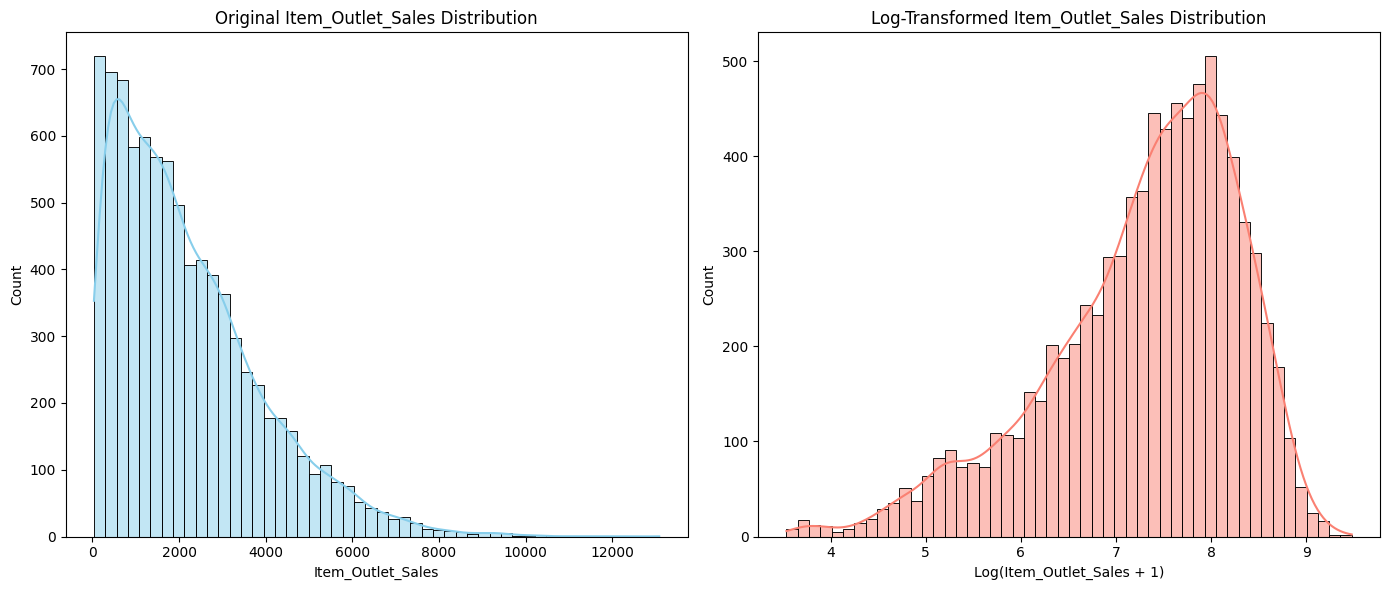

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Move to EDA : can only be done on train data

df = data[data['source'] == 'train'].copy()
df['Log_Sales'] = np.log1p(df['Item_Outlet_Sales'])

# === Plot ===
plt.figure(figsize=(14, 6))

# Original Sales
plt.subplot(1, 2, 1)
sns.histplot(df['Item_Outlet_Sales'], bins=50, kde=True, color='skyblue')
plt.title('Original Item_Outlet_Sales Distribution')
plt.xlabel('Item_Outlet_Sales')

# Log-transformed Sales
plt.subplot(1, 2, 2)
sns.histplot(df['Log_Sales'], bins=50, kde=True, color='salmon')
plt.title('Log-Transformed Item_Outlet_Sales Distribution')
plt.xlabel('Log(Item_Outlet_Sales + 1)')

plt.tight_layout()
plt.show()

In [29]:


# Optional for cleaner plot style
sns.set(style="whitegrid")

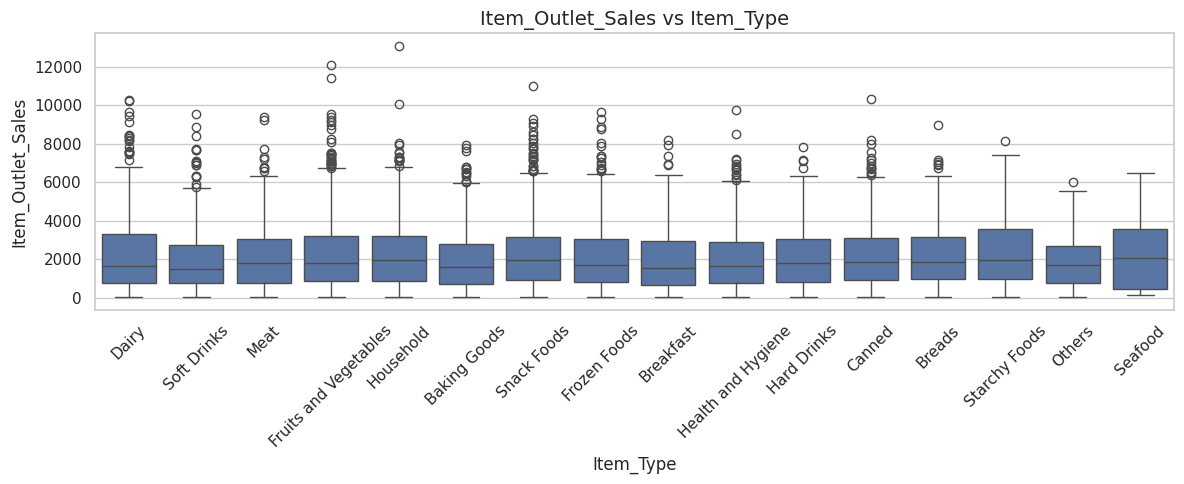

In [30]:
categorical_cols = [ 'Item_Type']

for col in categorical_cols:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x=col, y='Item_Outlet_Sales', data=data)
    plt.title(f'Item_Outlet_Sales vs {col}', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Insights of Sales from Item_Type

1. Median of Sales is similar across Item Types
2. Strong Presence of Outliers acrss all Item Types - maybe some products are performing better due to other features like visibility, outlet type
3. Most categories show right-skewed distributions (longer upper whiskers), which is typical in sales data, a few high selling items drive a large portion of revenue.



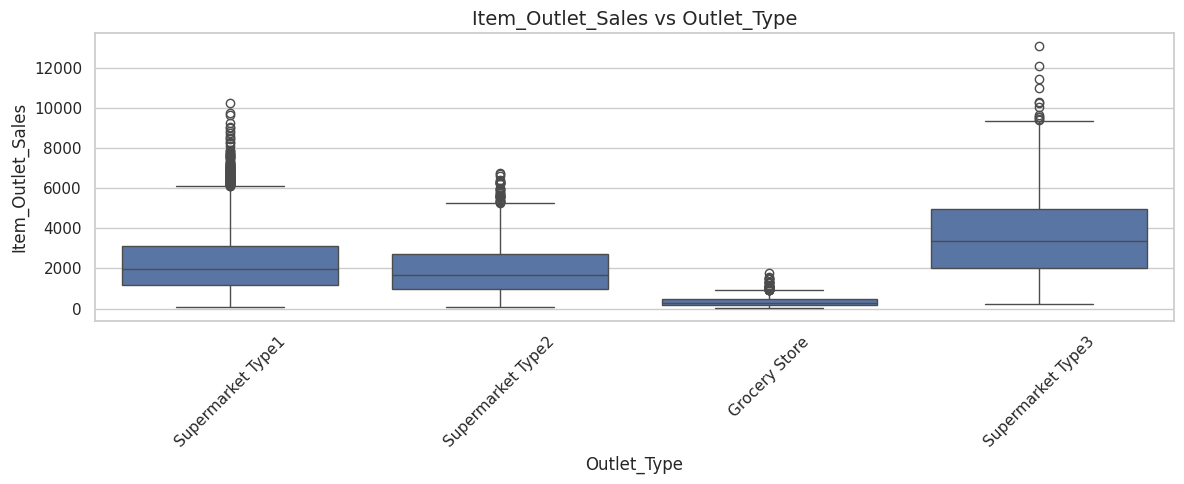

In [31]:
categorical_cols = ['Outlet_Type']

for col in categorical_cols:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x=col, y='Item_Outlet_Sales', data=data)
    plt.title(f'Item_Outlet_Sales vs {col}', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

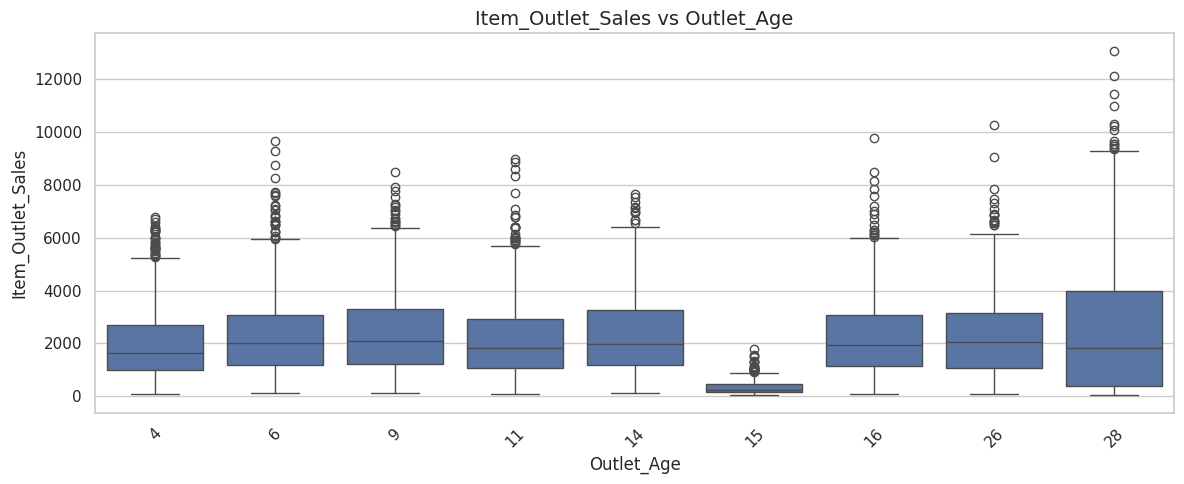

In [32]:
categorical_cols = ['Outlet_Age']

for col in categorical_cols:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x=col, y='Item_Outlet_Sales', data=data)
    plt.title(f'Item_Outlet_Sales vs {col}', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

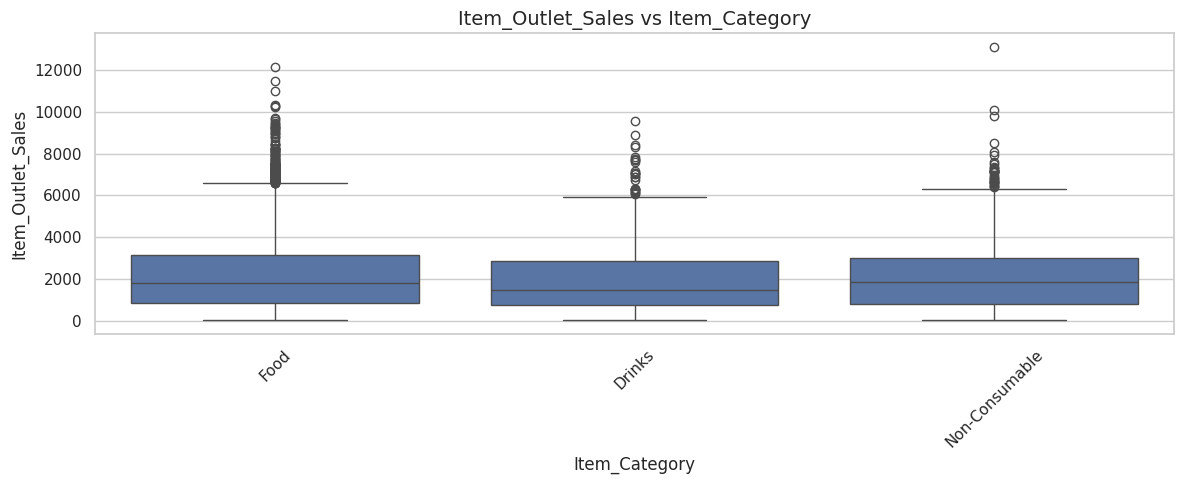

In [33]:
categorical_cols = ['Item_Category']

for col in categorical_cols:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x=col, y='Item_Outlet_Sales', data=data)
    plt.title(f'Item_Outlet_Sales vs {col}', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Insights of Sales from Outlet Information

1. Supermarket Type3 are top performers, whereas Grocery Stores Underperform
2. Supermarket Type 1 and 2 have similar distribution

Outlet Size and Location does not have much deviation among each other.


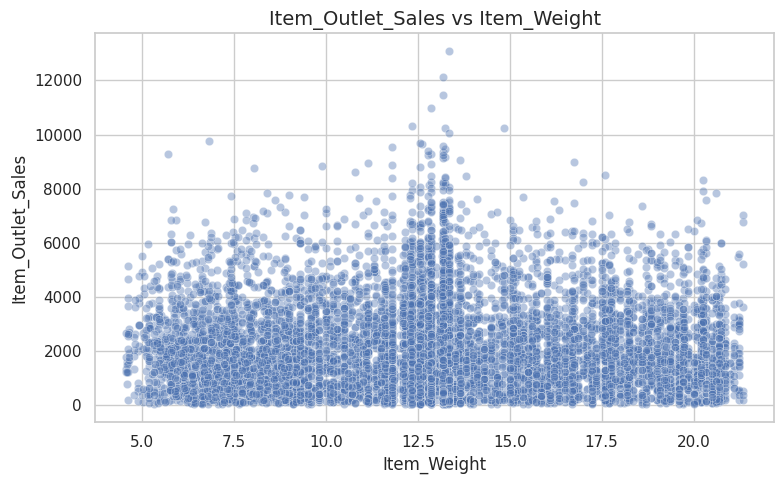

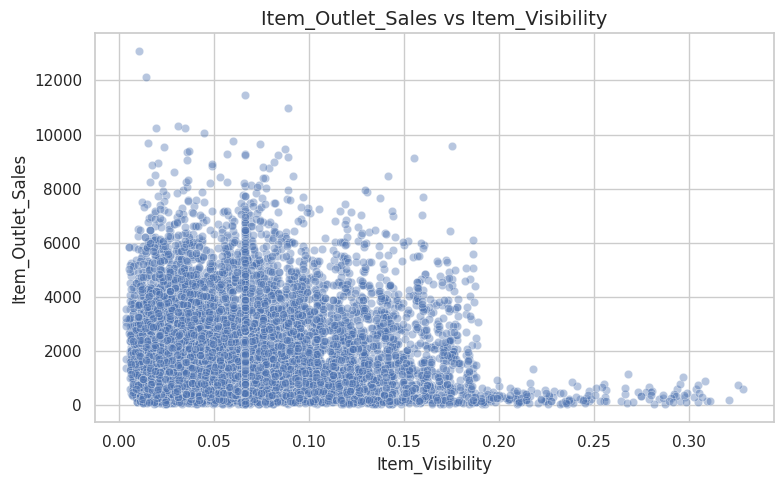

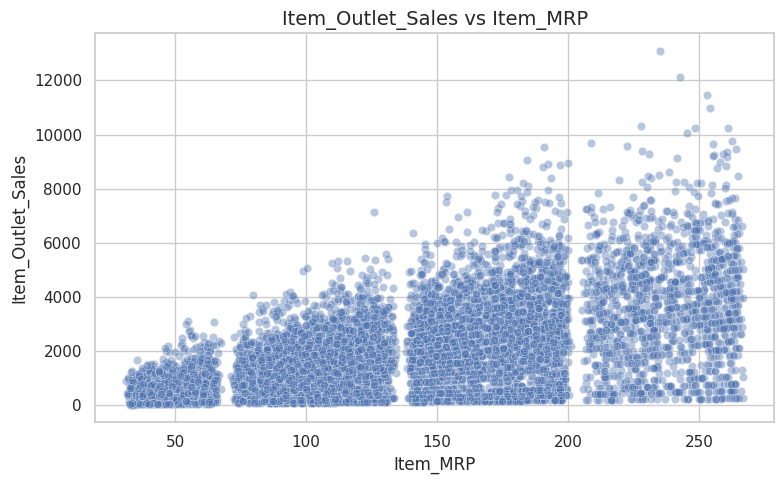

In [34]:
numerical_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP']

for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=col, y='Item_Outlet_Sales', data=data, alpha=0.4)
    plt.title(f'Item_Outlet_Sales vs {col}', fontsize=14)
    plt.tight_layout()
    plt.show()

#### Insights of Sales from Weight, MRP & Visibility

1. Item Weight does not have have a significant relationship with the Sales but Items with weight ~12.5 have greater sales
2. Visibility does not guareentee higher sales
3. We have fewer high MRP items but they contribute significantly to the overall sales.


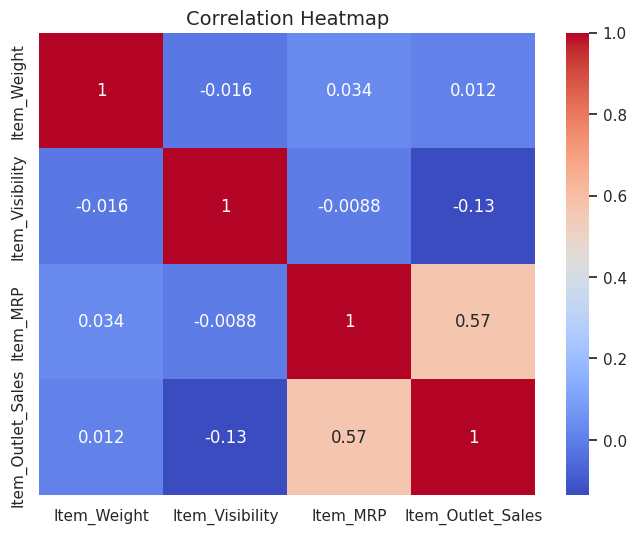

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(data[numerical_cols + ['Item_Outlet_Sales']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

In [36]:
### Removing outliers in sales

# Calculate thresholds
q99 = data['Item_Outlet_Sales'].quantile(0.99)
print("99th percentile:", q99)

# Count how many exceed the threshold
outlier_count = (data['Item_Outlet_Sales'] > q99).sum()
print(f"Number of values above 99th percentile: {outlier_count}")

# Cap at 99th percentile
data['Item_Outlet_Sales_Capped'] = data['Item_Outlet_Sales'].apply(lambda x: min(x, q99))

99th percentile: 7366.011720000013
Number of values above 99th percentile: 86


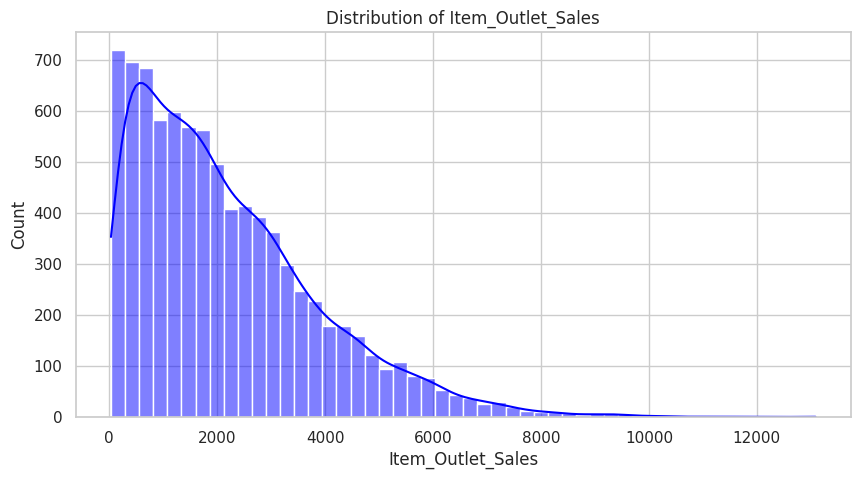

In [37]:
# Plot after capping
plt.figure(figsize=(10, 5))
sns.histplot(data['Item_Outlet_Sales'], bins=50, kde=True, color='blue')
plt.title("Distribution of Item_Outlet_Sales")
plt.show()

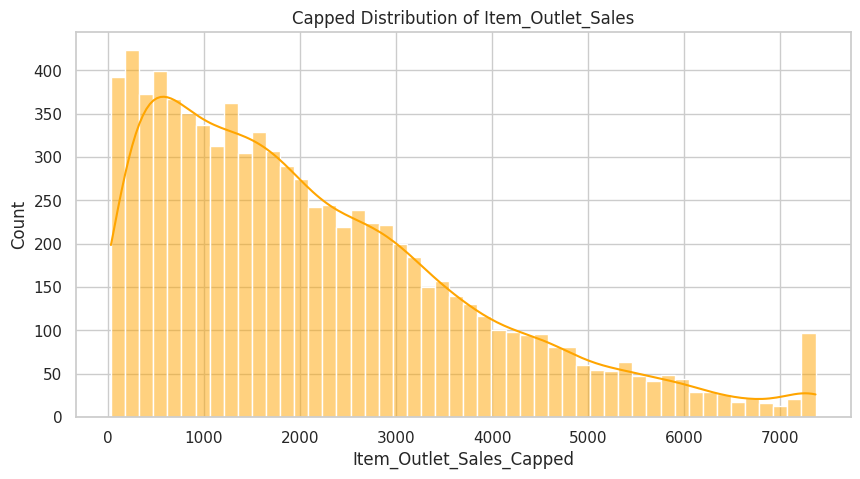

In [38]:
# Plot after capping
plt.figure(figsize=(10, 5))
sns.histplot(data['Item_Outlet_Sales_Capped'], bins=50, kde=True, color='orange')
plt.title("Capped Distribution of Item_Outlet_Sales")
plt.show()

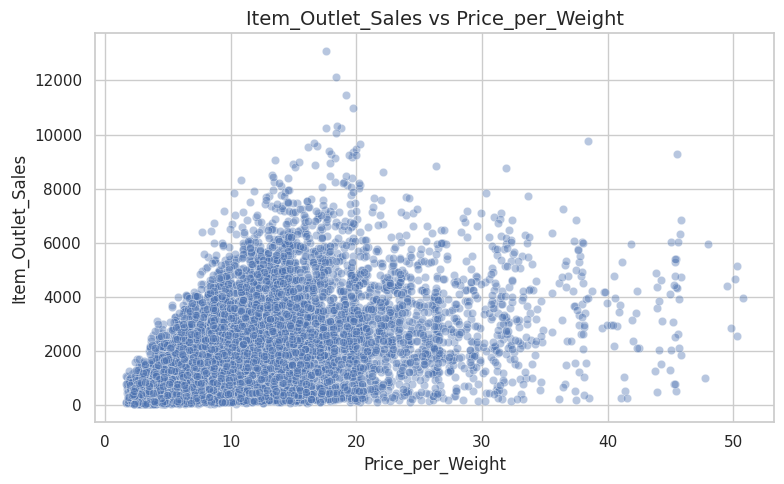

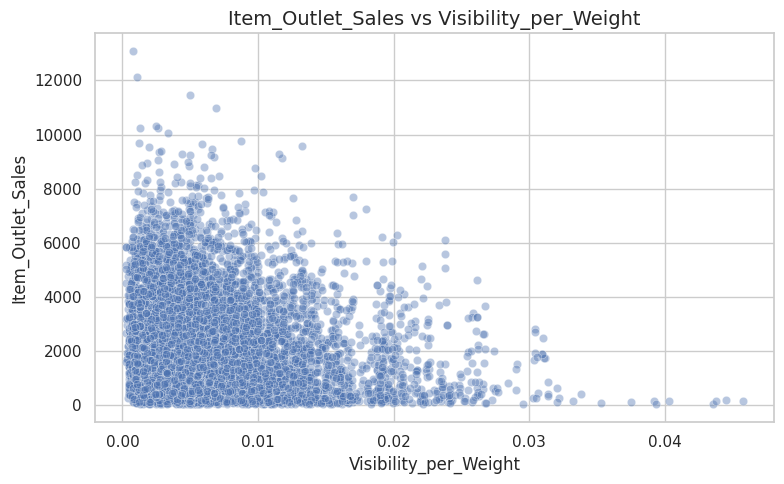

In [39]:
## Adding combination columns

numerical_cols = ['Price_per_Weight', 'Visibility_per_Weight']

for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=col, y='Item_Outlet_Sales', data=data, alpha=0.4)
    plt.title(f'Item_Outlet_Sales vs {col}', fontsize=14)
    plt.tight_layout()
    plt.show()

## Model Building : XGBoost

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [50]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'source', 'Item_Category',
       'Outlet_Age', 'High_Performing_Outlet', 'Price_per_Weight',
       'Visibility_per_Weight', 'Item_Outlet_Sales_Capped'],
      dtype='object')

In [51]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content               int64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier              int64
Outlet_Establishment_Year      int64
Outlet_Size                    int64
Outlet_Location_Type           int64
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
Item_Category                 object
Outlet_Age                     int64
High_Performing_Outlet         int64
Price_per_Weight             float64
Visibility_per_Weight        float64
Item_Outlet_Sales_Capped     float64
dtype: object

In [41]:
# Convert all object columns to category
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].astype('category')


In [53]:
data['Log_Sales'] = np.log1p(data['Item_Outlet_Sales_Capped'])

In [40]:
#features = ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Category','Outlet_Age','High_Performing_Outlet']
#features = ['Item_Weight', 'Item_Fat_Content', 'Visibility_per_Weight', 'Item_Type', 'Price_per_Weight','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Category','Outlet_Age','High_Performing_Outlet']


In [54]:
# Select features based on EDA insights
features = ['Item_Visibility', 'Item_MRP','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Category','Outlet_Age','High_Performing_Outlet']
target = 'Log_Sales'


In [55]:
# Split data into train and validation
train_df = data[data['source'] == 'train'].copy()
val_df = data[data['source'] == 'test'].copy()
val_df.drop(columns=['Log_Sales', 'Item_Outlet_Sales'], inplace=True)

In [56]:
val_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'source', 'Item_Category', 'Outlet_Age',
       'High_Performing_Outlet', 'Price_per_Weight', 'Visibility_per_Weight',
       'Item_Outlet_Sales_Capped'],
      dtype='object')

In [57]:
# === Split Data ===
X = train_df[features]
y = train_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [58]:
X_train.shape

(6818, 8)

In [59]:
X_test.shape

(1705, 8)

In [56]:
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}
xgb = XGBRegressor(objective='reg:squarederror', enable_categorical=True,random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,  # number of combinations to try
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best RMSE score from CV:", -random_search.best_score_)
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best RMSE score from CV: 1393.6727113721881
Best parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [64]:
model = random_search.best_estimator_

In [65]:
# Fit model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

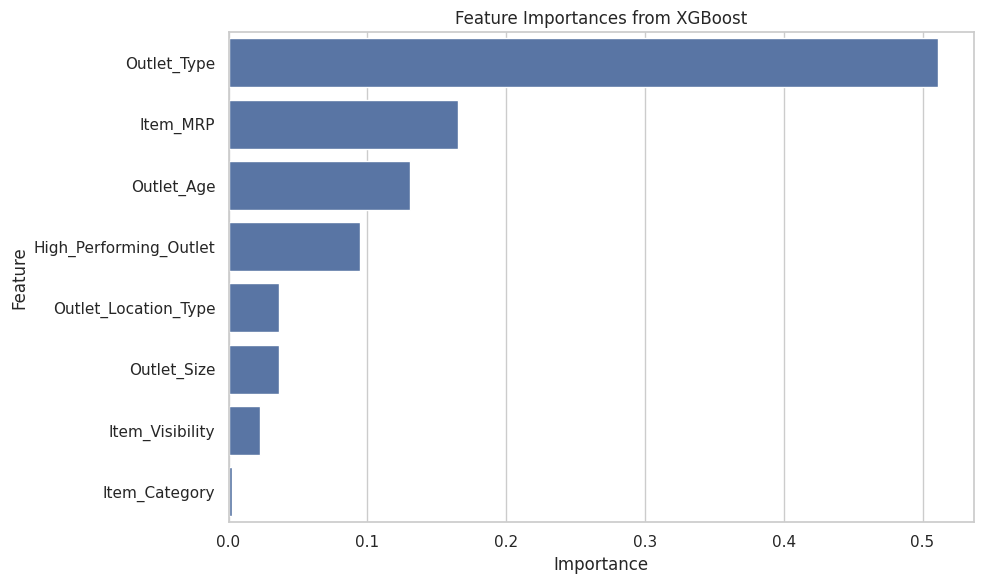

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model.feature_importances_

# Match with column names
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from XGBoost')
plt.tight_layout()
plt.show()

In [67]:
# Predict
y_pred = model.predict(X_test)


In [68]:
# Calculate RMSE & MAPE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE (log scale):", rmse)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Test MAPE (%) on log sclae:", mape)

Test RMSE (log scale): 0.5162894116186356
Test MAPE (%) on log sclae: 5.9091887669140215


In [69]:
y_pred_sales = np.expm1(y_pred)
y_test_sales = np.expm1(y_test)


In [70]:
# Calculate RMSE & MAPE
rmse = np.sqrt(mean_squared_error(y_test_sales, y_pred_sales))
print("Test RMSE (actual sales):", rmse)

mape = np.mean(np.abs((y_test_sales - y_pred_sales) / y_test_sales)) * 100
print("Test MAPE (%) on actual sales:", mape)

Test RMSE (actual sales): 1025.0977968108232
Test MAPE (%) on actual sales: 49.06971223008317


In [71]:
## Adding results back to test df 
test_results = X_test.copy()

# Add predicted sales
test_results['Predicted_Sales'] = y_pred_sales

# Optional: Add actual sales if present
test_results['Actual_Sales'] = y_test_sales

test_results.to_csv('test_results.csv', index=False)

# View result
test_results.head()

,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Category,Outlet_Age,High_Performing_Outlet,Predicted_Sales,Actual_Sales
7503,0.026300,79.4302,2,2,Supermarket Type1,Food,26,0,1120.972778,1743.0644
2957,0.071136,42.7086,0,0,Supermarket Type1,Non-Consumable,16,0,620.527954,356.8688
7031,0.041313,42.0454,1,0,Supermarket Type1,Food,14,0,644.945435,377.5086
1084,0.044767,173.7054,1,2,Supermarket Type3,Drinks,28,1,4025.713867,5778.4782
856,0.012456,197.5110,0,1,Supermarket Type1,Food,9,0,2934.100830,2356.9320


In [116]:
## Calculate RMSE by Item category

from sklearn.metrics import mean_squared_error

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_by_category = (
    test_results.groupby('High_Performing_Outlet')
    .apply(lambda df: calculate_rmse(df['Actual_Sales'], df['Predicted_Sales']))
    .reset_index(name='RMSE')
)

print(rmse_by_category)

   High_Performing_Outlet         RMSE
0                       0   986.639310
1                       1  1315.894441


In [73]:
## Analysing residuals 

# Residuals
residuals = y_test_sales - y_pred_sales

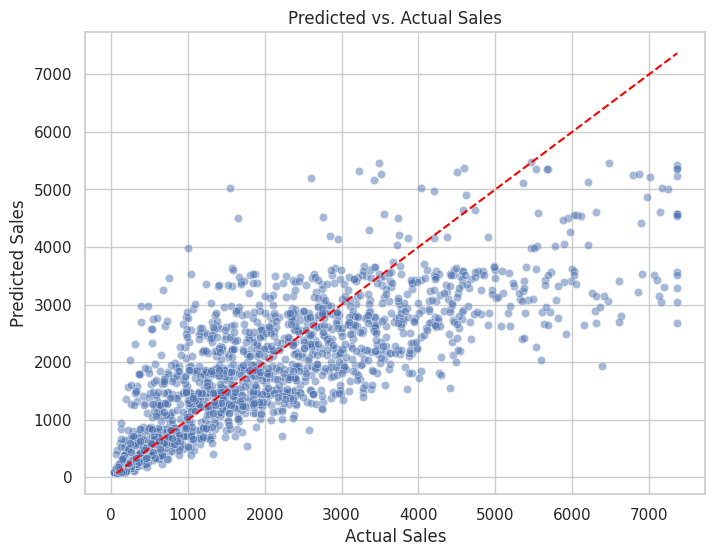

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_sales, y=y_pred_sales, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs. Actual Sales")
plt.plot([y_pred_sales.min(), y_test_sales.max()], 
         [y_pred_sales.min(), y_test_sales.max()], 
         color='red', linestyle='--')  # 45-degree reference line
plt.show()

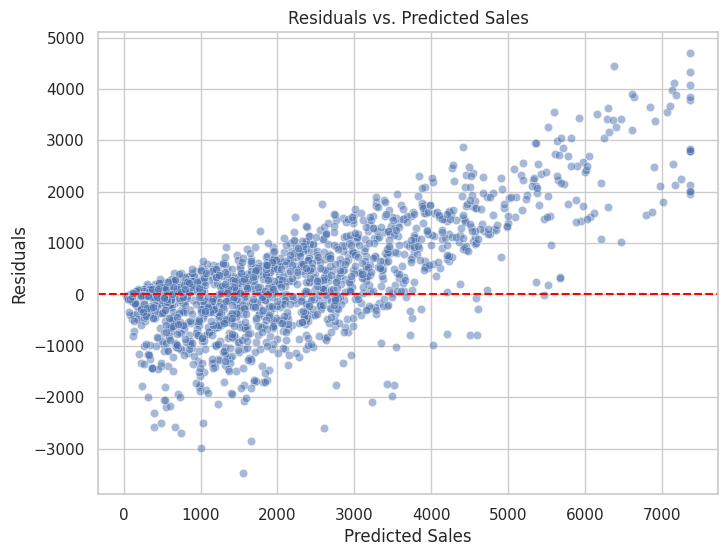

In [75]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_sales, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Sales")
plt.show()

In [76]:
#### Prediction on validation set

val = val_df[features]
# Predict
y_val = model.predict(val)
y_val_sales = np.expm1(y_val)

In [77]:
## Adding results back to val df 
val_results = val_df

# Add predicted sales
val_results['Item_Outlet_Sales'] = y_val_sales

# View result
val_results[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']].head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
8523,FDW58,9,1559.815796
8524,FDW14,2,1264.125000
8525,NCN55,0,535.609802
8526,FDQ58,2,2230.379639
8527,FDY38,5,5172.490723


In [467]:
submit = val_results[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
submit.to_csv('val_results.csv', index=False)

## Deep Learning Approach : 
Since the Big Mart Sales Prediction problem is a regression task on structured tabular data (not time series), 
the best deep learning models for this kind of problem are Feedforward Neural Networks (FNN), also known as Multilayer Perceptrons (MLPs).

- Your features are a mix of numerical and categorical variables.
- There's no temporal sequence — each row is independent.
- Deep learning can capture nonlinear relationships between features and the sales target.

 Feedforward Neural Networks (FNN), also known as Multilayer Perceptrons (MLPs)

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Dropout, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=10, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=700, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=700, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=300, reg_alpha=0.5, reg_lambda=1.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, n_estimators=700, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=500, reg_alpha=0, reg_lambda=1.5, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.01, max_dept

In [104]:
# 1. Preprocess numeric and categorical features
numeric_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']
categorical_features = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category']


In [105]:
# Scale numeric
scaler = StandardScaler()
X_num = scaler.fit_transform(data[numeric_features])


In [106]:
from sklearn.preprocessing import LabelEncoder
encoded_features = []
inputs = []
embeddings = []

In [107]:
for col in categorical_features:
    print(col)
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    input_cat = Input(shape=(1,))
    vocab_size = data[col].nunique()
    embed_dim = min(50, (vocab_size + 1) // 2)
    embed = Embedding(input_dim=vocab_size+1, output_dim=embed_dim)(input_cat)
    embed = Flatten()(embed)
    
    inputs.append(input_cat)
    embeddings.append(embed)

Item_Fat_Content
Item_Type
Outlet_Size
Outlet_Location_Type
Outlet_Type
Item_Category


In [108]:
# Input for numeric data
input_num = Input(shape=(X_num.shape[1],))
inputs.append(input_num)

In [109]:
# Concatenate all features
x = Concatenate()(embeddings + [input_num])
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dense(1)(x)

model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [110]:
## Filter for training data 

train_df = data[data['source'] == 'train'].copy()
val_df = data[data['source'] == 'test'].copy()

# Inputs
X_cat = [train_df[col].values for col in categorical_features]
X_num = scaler.transform(train_df[numeric_features])  # ensure it's already scaled
y = train_df['Item_Outlet_Sales'].values

# Split each categorical input separately
X_cat_train = []
X_cat_val = []
for arr in X_cat:
    X_train_part, X_val_part = train_test_split(arr, test_size=0.2, random_state=42)
    X_cat_train.append(X_train_part)
    X_cat_val.append(X_val_part)

# Split numeric features and target
X_num_train, X_num_val, y_train, y_val = train_test_split(X_num, y, test_size=0.2, random_state=42)

# Combine inputs for model
X_train = X_cat_train + [X_num_train]
X_val = X_cat_val + [X_num_val]

In [111]:
# Now fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)

Epoch 1/20
107/107 [==============================] - 3s 4ms/step - loss: 7684834.5000 - mae: 2175.8486 - val_loss: 6552856.5000 - val_mae: 1970.7944
Epoch 2/20
107/107 [==============================] - 0s 2ms/step - loss: 4760395.0000 - mae: 1580.2787 - val_loss: 2165110.5000 - val_mae: 1132.6599
Epoch 3/20
107/107 [==============================] - 0s 2ms/step - loss: 2175639.0000 - mae: 1149.2341 - val_loss: 1818891.0000 - val_mae: 1052.6782
Epoch 4/20
107/107 [==============================] - 0s 2ms/step - loss: 1858090.7500 - mae: 1049.9039 - val_loss: 1545519.5000 - val_mae: 954.8315
Epoch 5/20
107/107 [==============================] - 0s 2ms/step - loss: 1611413.8750 - mae: 960.6987 - val_loss: 1335200.7500 - val_mae: 870.2723
Epoch 6/20
107/107 [==============================] - 0s 2ms/step - loss: 1425681.3750 - mae: 881.8408 - val_loss: 1201373.1250 - val_mae: 802.2649
Epoch 7/20
107/107 [==============================] - 0s 2ms/step - loss: 1338836.0000 - mae: 839.9104 - 

In [112]:
y_pred_val = model.predict(X_val).flatten()  # Flatten to match shape of y_val


54/54 [==============================] - 0s 862us/step


In [114]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE & MAPE
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print("Test RMSE (actual sales) on Neural Network MLP:", rmse)

mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print("Test MAPE (%) on actual sales on Neural Network MLP:", mape)

Test RMSE (actual sales) on Neural Network MLP: 1030.178615003605
Test MAPE (%) on actual sales on Neural Network MLP: 55.874612142562896


## XGBoost Model for each Outlet Type


In [47]:


import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Define your feature list and target
features = ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
            'Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
            'Item_Category', 'Outlet_Age', 'High_Performing_Outlet']
target = 'Item_Outlet_Sales'

# Dictionary to store models and results
models = {}
rmse_results = {}
mape_results = {}


# Loop over each unique Outlet_Type
for outlet_type in df['Outlet_Type'].unique():
    #print(f"\n Training model for Outlet_Type: {outlet_type}")

    # Filter data for this outlet type
    train_df = data[data['source'] == 'train'].copy()
    subset = train_df[train_df['Outlet_Type'] == outlet_type].copy()

    # Encode categorical variables (if not done already)
    subset_encoded = pd.get_dummies(subset[features], drop_first=True)

    # Define target
    y = subset[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(subset_encoded, y, test_size=0.2, random_state=42)

    # Train model
    model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    # Predictions and RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100


    # Save results
    models[outlet_type] = model
    rmse_results[outlet_type] = rmse
    mape_results[outlet_type] = mape

    #print(f"RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# Final summary
print("\nModel Performance by Outlet_Type:")
for ot in rmse_results:
    print(f"{ot}: RMSE = {rmse_results[ot]:.2f}, MAPE = {mape_results[ot]:.2f}%")



Model Performance by Outlet_Type:
Supermarket Type1: RMSE = 1140.89, MAPE = 58.61%
Supermarket Type2: RMSE = 968.04, MAPE = 59.60%
Grocery Store: RMSE = 235.29, MAPE = 67.37%
Supermarket Type3: RMSE = 1491.70, MAPE = 42.62%


## XGBoost for each Item Type


In [59]:
# Define your feature list and target
features = ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Outlet_Type',
            'Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
            'Item_Category', 'Outlet_Age', 'High_Performing_Outlet']
target = 'Item_Outlet_Sales'

# Dictionary to store models and results
models = {}
rmse_results = {}
mape_results = {}

# Loop over each unique Outlet_Type
for item_type in data['Item_Type'].unique():
    #print(f"\n Training model for Item_Type: {item_type}")

    # Filter data for this outlet type
    train_df = data[data['source'] == 'train'].copy()
    subset = train_df[train_df['Item_Type'] == item_type].copy()

    # Encode categorical variables (if not done already)
    subset_encoded = pd.get_dummies(subset[features], drop_first=True)

    # Define target
    y = subset[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(subset_encoded, y, test_size=0.2, random_state=42)
    
#     ## CV
    
#     param_dist = {
#         'n_estimators': [100, 300, 500, 700],
#         'max_depth': [3, 5, 7, 10],
#         'learning_rate': [0.01, 0.05, 0.1, 0.2],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'gamma': [0, 0.1, 0.3, 0.5],
#         'reg_alpha': [0, 0.1, 0.5],
#         'reg_lambda': [1, 1.5, 2]
#     }
#     xgb = XGBRegressor(objective='reg:squarederror', enable_categorical=True,random_state=42)

#     random_search = RandomizedSearchCV(
#         estimator=xgb,
#         param_distributions=param_dist,
#         n_iter=25,  # number of combinations to try
#         scoring='neg_root_mean_squared_error',
#         cv=3,
#         verbose=2,
#         n_jobs=-1
#     )

#     random_search.fit(X_train, y_train)

#     print("Best RMSE score from CV:", -random_search.best_score_)
#     print("Best parameters:", random_search.best_params_)
    
    
    
    # Train model
    model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    #model = random_search.best_estimator_
    model.fit(X_train, y_train)

    # Predictions and RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100


    # Save results
    models[item_type] = model
    rmse_results[item_type] = rmse
    mape_results[item_type] = mape

    #print(f"RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# Final summary
print("\nModel Performance by Item_Type:")
for ot in rmse_results:
    print(f"{ot}: RMSE = {rmse_results[ot]:.2f}, MAPE = {mape_results[ot]:.2f}%")



Model Performance by Item_Type:
Dairy: RMSE = 1299.91, MAPE = 53.18%
Soft Drinks: RMSE = 1144.30, MAPE = 71.14%
Meat: RMSE = 1279.61, MAPE = 96.08%
Fruits and Vegetables: RMSE = 1250.93, MAPE = 73.13%
Household: RMSE = 1202.64, MAPE = 64.34%
Baking Goods: RMSE = 1086.19, MAPE = 74.12%
Snack Foods: RMSE = 1115.01, MAPE = 72.54%
Frozen Foods: RMSE = 1085.80, MAPE = 71.27%
Breakfast: RMSE = 1260.12, MAPE = 152.31%
Health and Hygiene: RMSE = 1043.75, MAPE = 79.43%
Hard Drinks: RMSE = 1275.60, MAPE = 35.83%
Canned: RMSE = 954.33, MAPE = 56.45%
Breads: RMSE = 1288.96, MAPE = 59.76%
Starchy Foods: RMSE = 1536.80, MAPE = 93.30%
Others: RMSE = 1026.12, MAPE = 93.71%
Seafood: RMSE = 1997.31, MAPE = 144.96%
